In [21]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import comcloak
try:
    import comcloak
except ImportError as e:
    # Install comcloak if package is not already installed
    import os
    import sys
    print("Current directory:", os.getcwd())
    sys.path.append("D:\\sionna-main\\")
    # os.system("pip install comcloak")
    import comcloak

# Load the required comcloak components
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

from comcloak.mimo import StreamManagement

from comcloak.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from comcloak.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers

from comcloak.channel.tr38901 import AntennaArray, CDL, Antenna
from comcloak.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, time_lag_discrete_time_channel
from comcloak.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel

from comcloak.fec.ldpc.encoding import LDPC5GEncoder
from comcloak.fec.ldpc.decoding import LDPC5GDecoder

from comcloak.mapping import Mapper, Demapper

from comcloak.utils import BinarySource, ebnodb2no, sim_ber
from comcloak.utils.metrics import compute_ber
import tensorflow as tf
import torch
import scipy.io as sio
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
# gpus = tf.config.list_physical_devices('GPU')
# print("Available GPUs:", gpus)
# print(f"可用的GPU数量: {len(gpus)}")
# if gpus:
#     try:
#         tf.config.experimental.set_memory_growth(gpus[0], True)
#     except RuntimeError as e:
#         print(e)
# # Avoid warnings from TensorFlow
# tf.get_logger().setLevel('ERROR')
# comcloak.config.xla_compat=False
# GPU configuration
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"检测到 {num_gpus} 块 GPU:")
    for i in range(num_gpus):
        print(f"  - GPU {i}: {torch.cuda.get_device_name(i)}")
    device = torch.device("cuda")  # 默认用第一块 GPU
else:
    print("未检测到 GPU,使用 CPU")
    device = torch.device("cpu")

# Define the number of UT and BS antennas.
# For the CDL model, that will be used in this notebook, only
# a single UT and BS are supported.
num_ut = 1
num_bs = 1
num_ut_ant = 1
num_bs_ant = 1

# The number of transmitted streams is equal to the number of UT antennas
# in both uplink and downlink
num_streams_per_tx = 1
# Create an RX-TX association matrix
# rx_tx_association[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change. However, as we have only a single
# transmitter and receiver, this does not matter:
rx_tx_association = np.array([[1]])

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly easy. However, it can get more involved
# for simulations with many transmitters and receivers.
sm = StreamManagement(rx_tx_association, num_streams_per_tx)
fft_size=64
cyclic_prefix_length=16
num_ofdm_symbols=14
rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=64,
                  subcarrier_spacing=15e3,
                  num_tx=1,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=16,
                  num_guard_carriers=[5,6],
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11])


carrier_frequency = 3.9e9 # Carrier frequency in Hz.
                          # This is needed here to define the antenna element spacing.

ut_array = AntennaArray(num_rows=1,
                        num_cols=num_ut_ant,
                        polarization="single",
                        polarization_type="V",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
# ut_array.show()

bs_array = AntennaArray(num_rows=1,
                        num_cols=num_bs_ant,
                        polarization="single",
                        polarization_type="V",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
# bs_array.show()

delay_spread = 300e-9 # Nominal delay spread in [s]. Please see the CDL documentation
                      # about how to choose this value. 

direction = "downlink"  # The `direction` determines if the UT or BS is transmitting.
                      # In the `uplink`, the UT is transmitting.
cdl_model = "B"       # Suitable values are ["A", "B", "C", "D", "E"]

speed = 1            # UT speed [m/s]. BSs are always assumed to be fixed.
                      # The direction of travel will chosen randomly within the x-y plane.

# Configure a channel impulse reponse (CIR) generator for the CDL model.
# cdl() will generate CIRs that can be converted to discrete time or discrete frequency.
cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, direction, min_speed=speed)
# a, tau = cdl(batch_size=8, num_time_steps=rg.num_ofdm_symbols, sampling_frequency=1/rg.ofdm_symbol_duration)

# The following values for truncation are recommended.
# Please feel free to tailor them to you needs.
# l_min, l_max = time_lag_discrete_time_channel(rg.bandwidth)
# l_tot = l_max-l_min+1
# a, tau = cdl(batch_size=2, num_time_steps=rg.num_time_samples+l_tot-1, sampling_frequency=rg.bandwidth)

# print("Shape of the path gains: ", a.shape)
# print("Shape of the delays:", tau.shape)
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)
# h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=True)
# Function that will apply the channel frequency response to an input signal
channel_freq = ApplyOFDMChannel(add_awgn=True)
# Function that will apply the discrete-time channel impulse response to an input signal
# channel_time = ApplyTimeChannel(rg.num_time_samples, l_tot=l_tot, add_awgn=True)


num_bits_per_symbol = 6 # QPSK modulation
coderate = 0.5 # Code rate
n = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource()

# The encoder maps information bits to coded bits
encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# The zero forcing precoder precodes the transmit stream towards the intended antennas
zf_precoder = ZFPrecoder(rg, sm, return_effective_channel=True)

# OFDM modulator and demodulator
modulator = OFDMModulator(rg.cyclic_prefix_length)
l_min = 0  # Should be set according to the channel model used
demodulator = OFDMDemodulator(rg.fft_size, l_min, rg.cyclic_prefix_length)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)

# The LS channel estimator will provide channel estimates and error variances
ls_est = LSChannelEstimator(rg, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = LMMSEEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
decoder = LDPC5GDecoder(encoder, hard_out=True)


检测到 1 块 GPU:
  - GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU


In [22]:
batch_size = 8 # We pick a small batch_size as executing this code in Eager mode could consume a lot of memory
ebno_db = 10

no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)
b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)

cir = cdl(batch_size, rg.num_ofdm_symbols, 1/rg.ofdm_symbol_duration)
h_freq = cir_to_ofdm_channel(frequencies, *cir, normalize=True)
x_rg, g = zf_precoder([x_rg, h_freq])


# OFDM modulation with cyclic prefix insertion
x_time = modulator(x_rg)
# torch.save(x_time, 'D:\\sionna-main\\practical\\wave_data.pt')
# x_signal = torch.load('D:\\sionna-main\\practical\\wave_data64.pt')
# mat = sio.loadmat("d:/sionna-main/practical/adc_data/adc_data3.mat")
# adc_data = mat["adc_data"]
# y_time = torch.tensor(adc_data, dtype=torch.complex64).to(device).T
# y_time = y_time[0]

ch1 = np.load('D:\\sionna-main\\64QAMch1.npy')
y_time = torch.tensor(ch1, dtype=torch.complex64).to(device).T



# mat2 = sio.loadmat("d:/sionna-main/practical/sim_data.mat")
# adc_data = mat2["data_compen2"]
# y_time = torch.tensor(adc_data, dtype=torch.complex64).to(device).T

precusor_length = 405#?320+80#[410, 417]
y_time = y_time[precusor_length:precusor_length+num_ofdm_symbols*(cyclic_prefix_length+fft_size)*batch_size]
y_time = y_time.reshape(batch_size, 1, 1, -1)
# OFDM demodulation and cyclic prefix removal
y = demodulator(y_time)

h_hat, err_var = ls_est ([y, no])

x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])


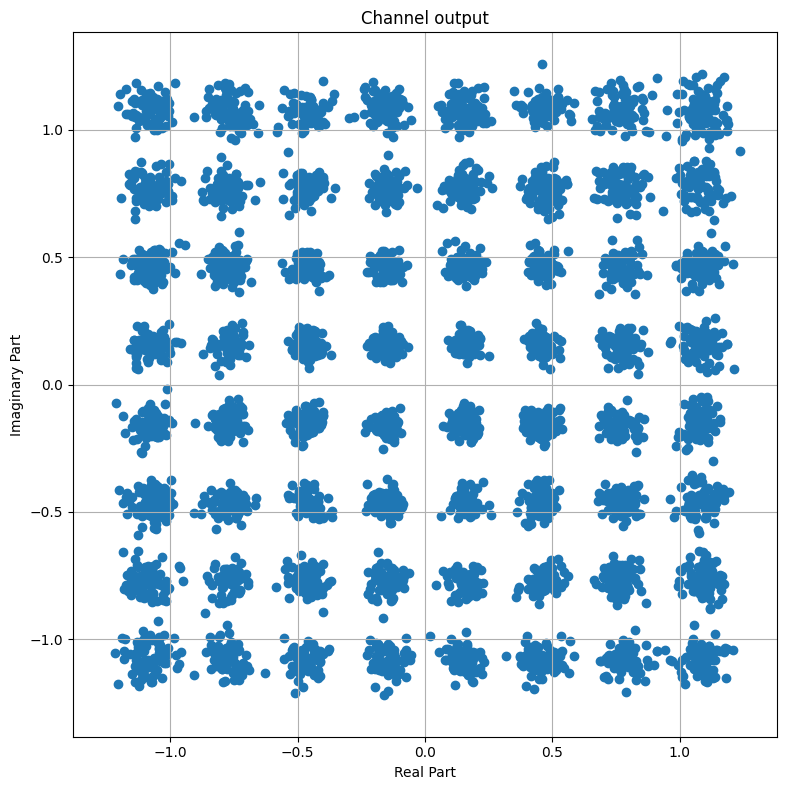

In [23]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
x_hat_np = x_hat.detach().cpu().numpy()
y_np = y.detach().cpu().numpy()
plt.scatter(np.real(x_hat_np), np.imag(x_hat_np))
max_abs = max(np.abs(np.real(x_hat_np)).max(), 
              np.abs(np.imag(x_hat_np)).max()) * 1.1  # 加10%边距
# plt.scatter(np.real(y_np), np.imag(y_np))
# max_abs = max(np.abs(np.real(y_np)).max(), 
#               np.abs(np.imag(y_np)).max()) * 1.1  # 加10%边距
plt.xlim(-max_abs, max_abs)
plt.ylim(-max_abs, max_abs)
plt.tight_layout()

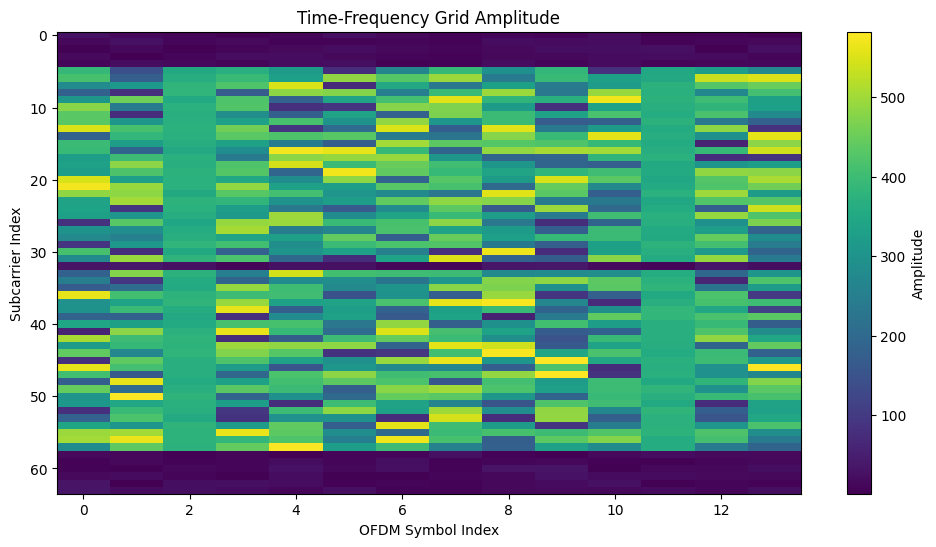

In [24]:
y_abs = y[0].squeeze().abs().T
y_abs = y_abs.detach().cpu().numpy()
plt.figure(figsize=(12, 6))
plt.imshow(y_abs, aspect='auto', interpolation='nearest', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.xlabel('OFDM Symbol Index')
plt.ylabel('Subcarrier Index')
plt.title('Time-Frequency Grid Amplitude')
plt.show()

In [25]:
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
b_cuda = b.to(device)
ber = compute_ber(b_cuda, b_hat)
print("BER: {}".format(ber))

BER: 0.0
